# What is the DCE inside each BAF? 
## before and after treatments on Cle Elum Ridge   

### Notebook contents 
* Copied from notebook 7 to start after the defense.
* Start addressing forest structure with BAF and DCE...

created by Cassie Lumbrazo\
date: January 2024\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

## Add a CHM buffer for edge effects of RAPID lidar data 
To do the buffer, we want to buffer the rapid chm, then clip the other two chm to the rapid model

In [4]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

Should do this at the begining, clip the entire dataset to it, then move on

In [5]:
ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

## Calculations for change in forest structure depending on aspect

In [6]:
ds

<xarray.Dataset>
Dimensions:                   (band: 1, y: 1388, x: 2564)
Coordinates:
  * x                         (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                         (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                      (band) int32 1
    spatial_ref               int32 0
Data variables: (12/38)
    hs_rapid_set1             (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set2             (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3             (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set2_maskpiles   (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3_maskpiles   (band, y, x) float32 nan nan nan ... nan nan nan
    chmws_rapid               (band, y, x) float32 nan nan nan ... nan nan nan
    ...                        ...
    giulia_dce_rapid_reclass  (band, y, x) float64 nan nan nan ... nan nan nan
    dce_ncalm_reclass         (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid                  (band, y, x) float32 nan nan nan ... nan nan nan
    chmas_rapid               (band, y, x) float32 nan nan nan ... nan nan nan
    chm_mask                  (band, y, x) float32 nan nan nan ... nan nan nan
    chmws_rapid_raw           (band, y, x) float32 nan nan nan ... nan nan nan

In [7]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

In [8]:
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

In [9]:
# create binary variable for baf
ds['baf_canopychange_binary'] = np.nan 
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(~(ds['baf'] > 0), 1) # any BAF means canopy change
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

# also, create this variable to call later with the lidar change
ds['baf_canopychange'] = ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 1, np.nan)
ds['baf_nocanopychange']= ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 0, np.nan)

Aspect and Heat Index
* create binary objects for these also

In [10]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0), 1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] < 0), -1) # where DAH is less than or equal to 0, then -1 for low heat index
ds['dah_binary'] = ds['dah_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [11]:
# the numbers above show the calculate bounds for this option
ds['aspect_north'] = ds['aspect'].where((ds['aspect'] >= 325) | (ds['aspect'] <= 55)) # greater than 300 or less than 120 north
ds['aspect_south'] = ds['aspect'].where((ds['aspect'] >= 155) & (ds['aspect'] <= 245)) # between 120 and 300 south

# also, create an aspect binary variable to use later 
ds['aspect_binary'] = np.nan
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 325) | (ds['aspect'] <= 55)), 0) # where not false (true) fill 0
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 155) & (ds['aspect'] <= 245)), 1) 

# therefore, south is 0 and north is 1 
ds['aspect_binary'] = ds['aspect_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

Find where the forest changed or did not, on each aspect 

In [12]:
# with baf canopy change
# aspect 
ds['baf_canopychange_north'] = ds['baf_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_canopychange_south'] = ds['baf_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['baf_nocanopychange_north'] = ds['baf_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_nocanopychange_south'] = ds['baf_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['baf_canopychange_dahneg'] = ds['baf_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_canopychange_dahpos'] = ds['baf_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['baf_nocanopychange_dahneg'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_nocanopychange_dahpos'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

In [13]:
# same, with baf canopy change
ds['hs_baf_canopychange_north'] = ds['hs_rapid'].where(ds['baf_canopychange_north'].notnull())
ds['hs_baf_canopychange_south'] = ds['hs_rapid'].where(ds['baf_canopychange_south'].notnull())
ds['hs_baf_nocanopychange_north'] = ds['hs_rapid'].where(ds['baf_nocanopychange_north'].notnull())
ds['hs_baf_nocanopychange_south'] = ds['hs_rapid'].where(ds['baf_nocanopychange_south'].notnull())

ds['hs_baf_canopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['hs_baf_canopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['hs_baf_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['hs_baf_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

Create distance to canopy edge groups 

In [14]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_rapid_largeclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 100)
ds['dce_rapid_smallclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 200)
ds['dce_rapid_canopyedges']   = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 300)
ds['dce_rapid_smallgaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 400)
ds['dce_rapid_largegaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 500)

In [15]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_ncalm_largeclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 100)
ds['dce_ncalm_smallclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 200)
ds['dce_ncalm_canopyedges']   = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 300)
ds['dce_ncalm_smallgaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 400)
ds['dce_ncalm_largegaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 500)

In [16]:
ds['dce_rapid_reclass'].values.flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

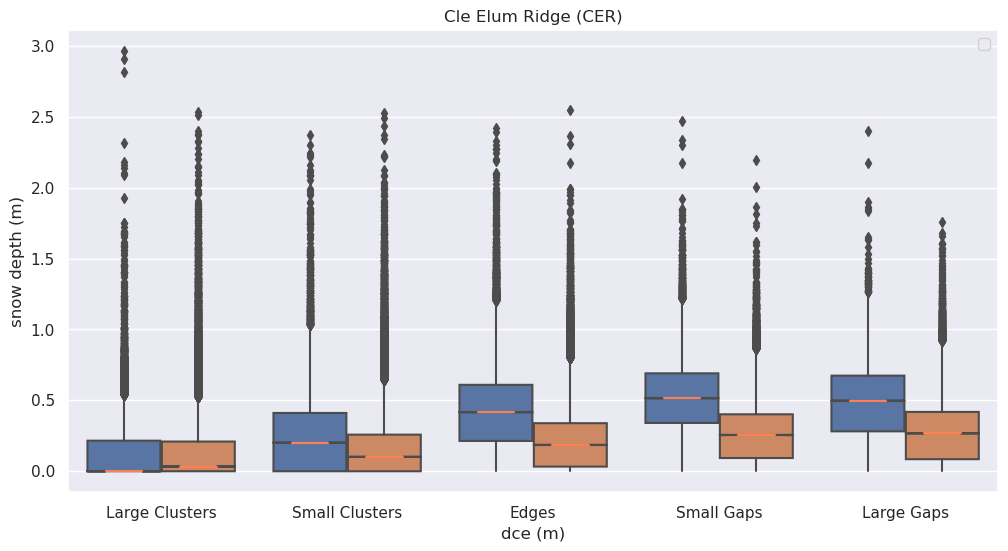

In [17]:
plt.figure(figsize=(12,6))

sns.boxplot(x=ds['dce_rapid_reclass'].values.flatten(), y=ds['hs_rapid'].values.flatten(), hue=ds['dah_reclass'].values.flatten(), notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel('dce (m)')
plt.ylabel('snow depth (m)')
plt.title('Cle Elum Ridge (CER)')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
plt.legend('')
# 100: large clusters, 200: small clusters, 300: edges, 400: small gaps, 500: large gaps 

plt.show()

## Raster Plots

In [19]:
# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

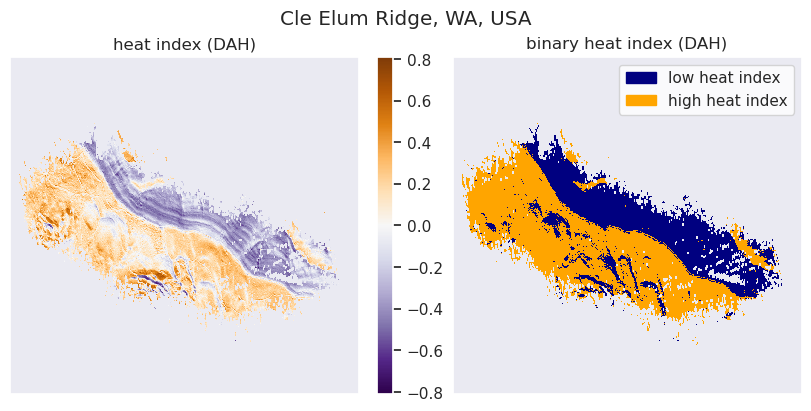

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.dah.plot(ax=axes[0], cmap='PuOr_r', cbar_kwargs={'label':''})
ds['dah_binary'].plot(ax=axes[1], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False)  


# Add a legend for labels, to have different labels for each plot
legend_labels2 = {"navy": "low heat index", 
                 "orange": "high heat index"}                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[0].set_title('heat index (DAH)')
axes[1].set_title('binary heat index (DAH)')
# axes[2].set_title('')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

# axes[2].set_xlabel('')
# axes[2].set_ylabel('') 
# axes[2].set_xticks([])
# axes[2].set_yticks([])

plt.show()

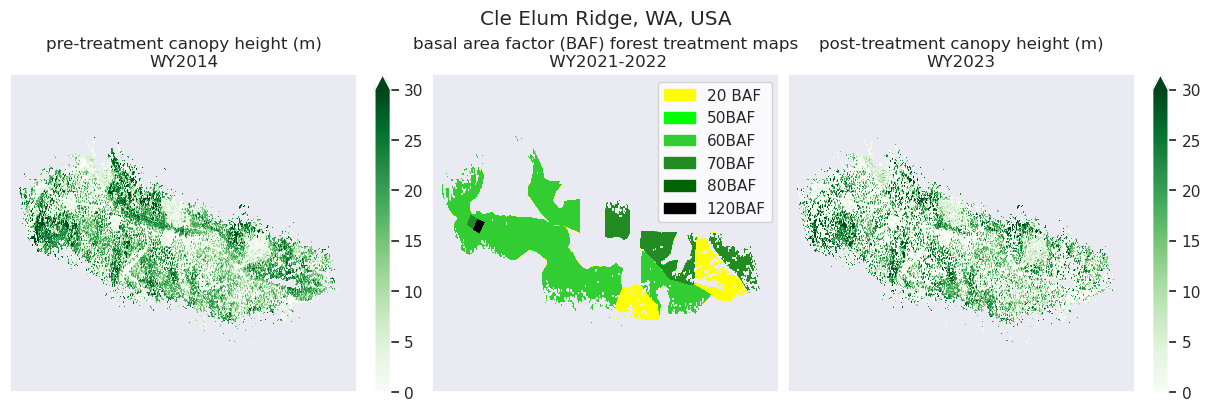

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.chm_snowoff.plot(ax=axes[0], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})
ds.baf.plot(ax=axes[1], cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)
ds.chmws_rapid.plot(ax=axes[2], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})  


# Add a legend for labels for baf
legend_labels = {"yellow": "20 BAF", 
                 "lime": "50BAF",
                 "limegreen": "60BAF",
                 "forestgreen": "70BAF",
                 "darkgreen": "80BAF",
                 "black": "120BAF"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")


axes[0].set_title('pre-treatment canopy height (m)\nWY2014')
axes[1].set_title('basal area factor (BAF) forest treatment maps\n WY2021-2022')
axes[2].set_title('post-treatment canopy height (m)\nWY2023')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

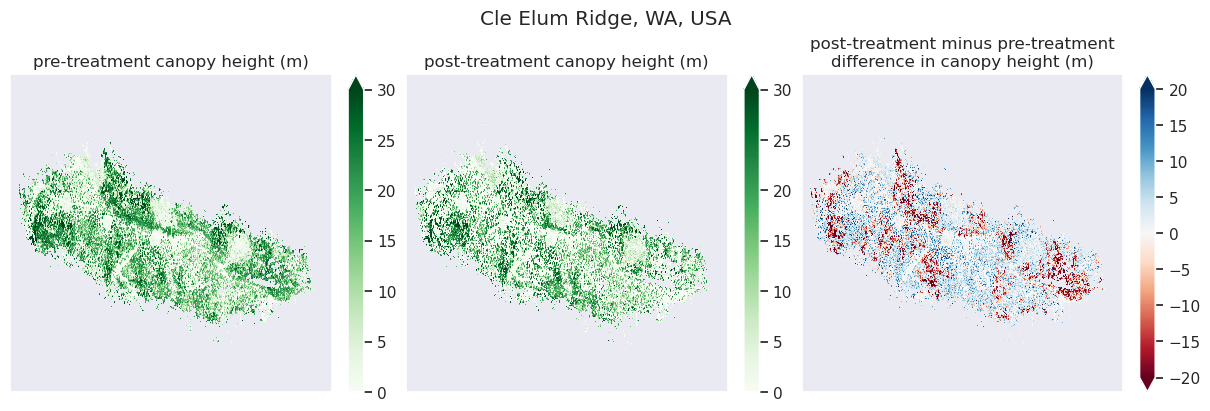

In [20]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.chm_snowoff.plot(ax=axes[0], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})
ds.chmws_rapid.plot(ax=axes[1], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})  
ds.diff_chm_rapid_ncalm.plot(ax=axes[2], vmin=-20, vmax=20, cmap='RdBu', cbar_kwargs={'label':''})

# ds.baf.plot(ax=axes[1], cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)

# # Add a legend for labels for baf
# legend_labels = {"yellow": "20 BAF", 
#                  "lime": "50BAF",
#                  "limegreen": "60BAF",
#                  "forestgreen": "70BAF",
#                  "darkgreen": "80BAF",
#                  "black": "120BAF"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# axes[1].legend(handles=patches,
#           bbox_to_anchor=(1, 1),
#           facecolor="white")


axes[0].set_title('pre-treatment canopy height (m)')
# axes[1].set_title('basal area factor (BAF) forest treatment maps\n WY2021-2022')
axes[1].set_title('post-treatment canopy height (m)')
axes[2].set_title('post-treatment minus pre-treatment\ndifference in canopy height (m)')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

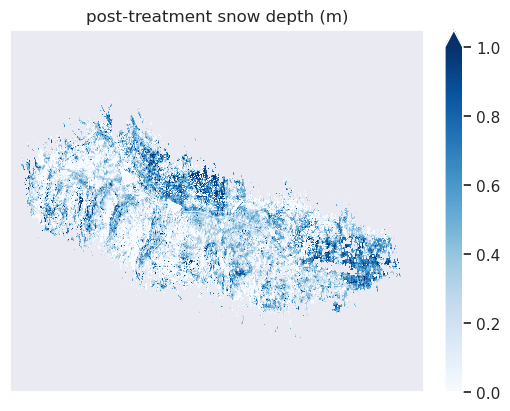

In [21]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,4), constrained_layout = True)

ds.hs_rapid.plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

axes.set_title('post-treatment snow depth (m)')

axes.set_xlabel('')
axes.set_ylabel('') 
axes.set_xticks([])
axes.set_yticks([])

plt.show()

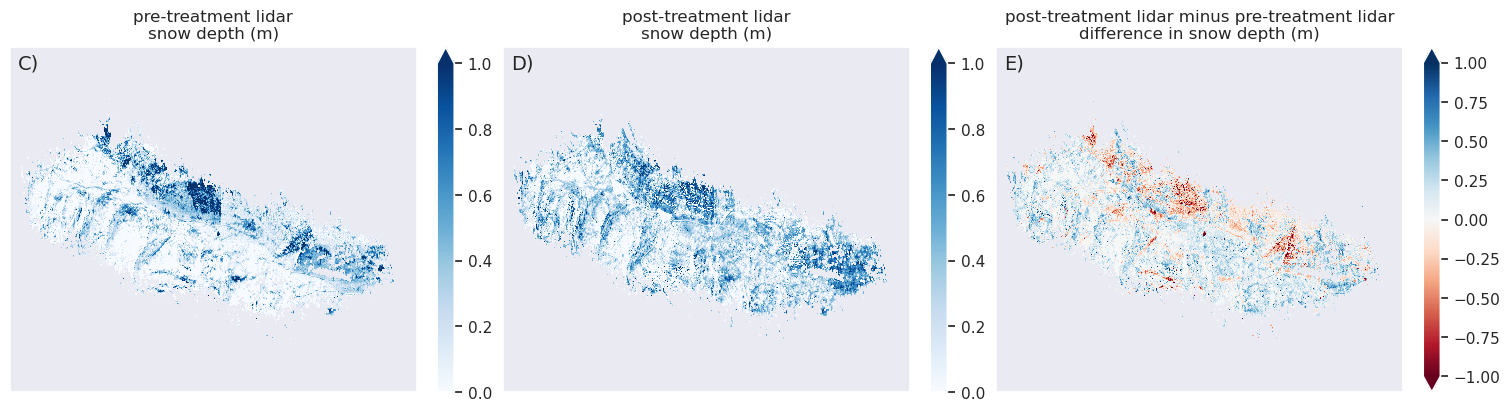

In [22]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 3 
ds.hs_ncalm.plot(ax=axes[0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[0].set_title('pre-treatment lidar\nsnow depth (m)')
axes[1].set_title('post-treatment lidar\nsnow depth (m)')
axes[2].set_title('post-treatment lidar minus pre-treatment lidar\ndifference in snow depth (m)')


axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

# add A) B) C) labels to the subplots in the top left corner 
axes[0].text(0.02, 0.98, 'C)', transform=axes[0].transAxes, fontsize=14,  va='top')
axes[1].text(0.02, 0.98, 'D)', transform=axes[1].transAxes, fontsize=14,  va='top')
axes[2].text(0.02, 0.98, 'E)', transform=axes[2].transAxes, fontsize=14,  va='top')

plt.show()

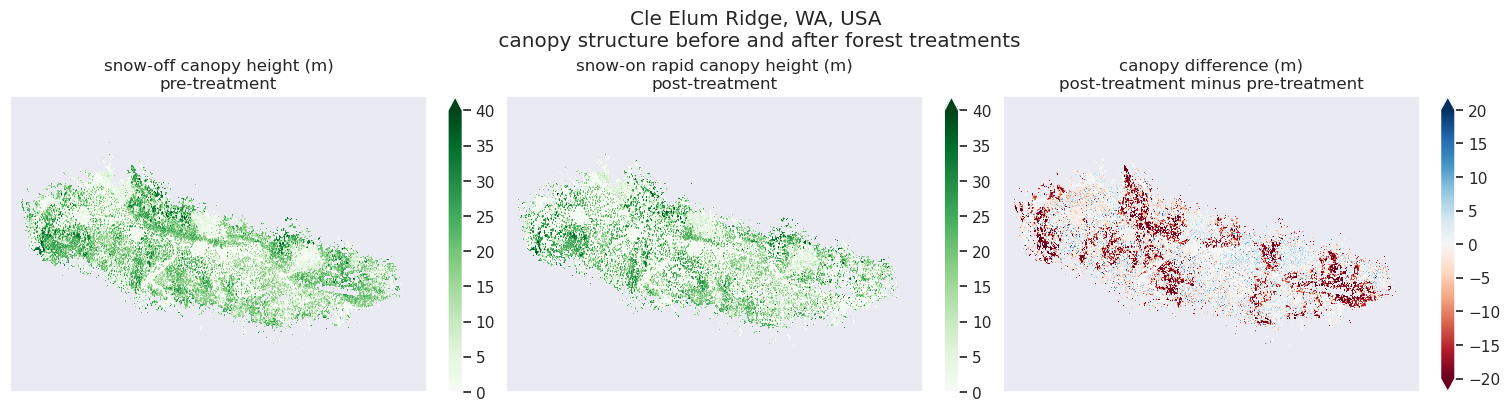

In [23]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

ds.chm_snowoff.plot(ax=axes[0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_snowoff.plot(ax=axes[2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0].set_title('snow-off canopy height (m)\npre-treatment')
axes[1].set_title('snow-on rapid canopy height (m)\npost-treatment')
axes[2].set_title('canopy difference (m)\npost-treatment minus pre-treatment')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

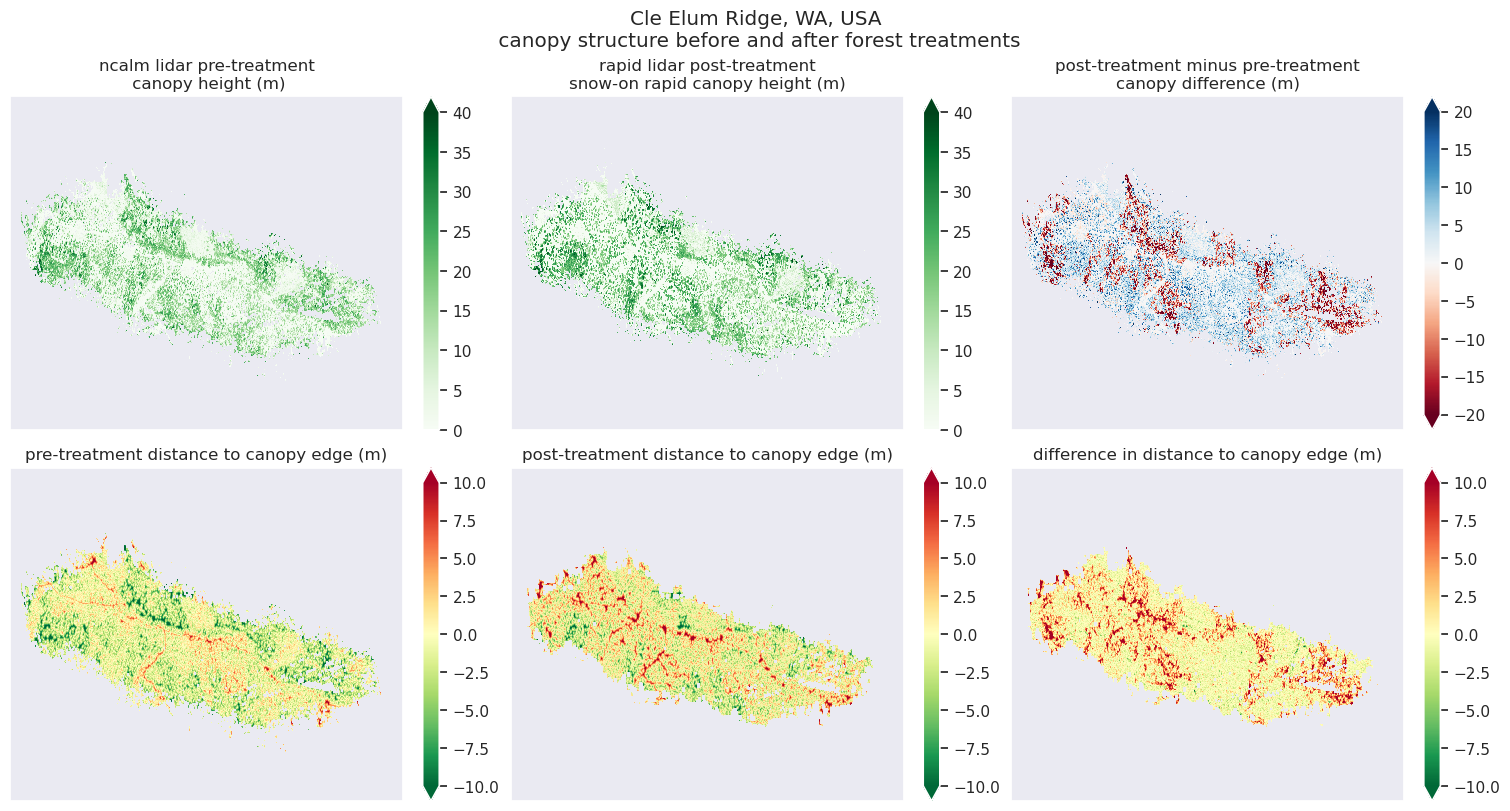

In [26]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('ncalm lidar pre-treatment\n canopy height (m)')
axes[0,1].set_title('rapid lidar post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# # row 3 
# axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
# axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
# axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

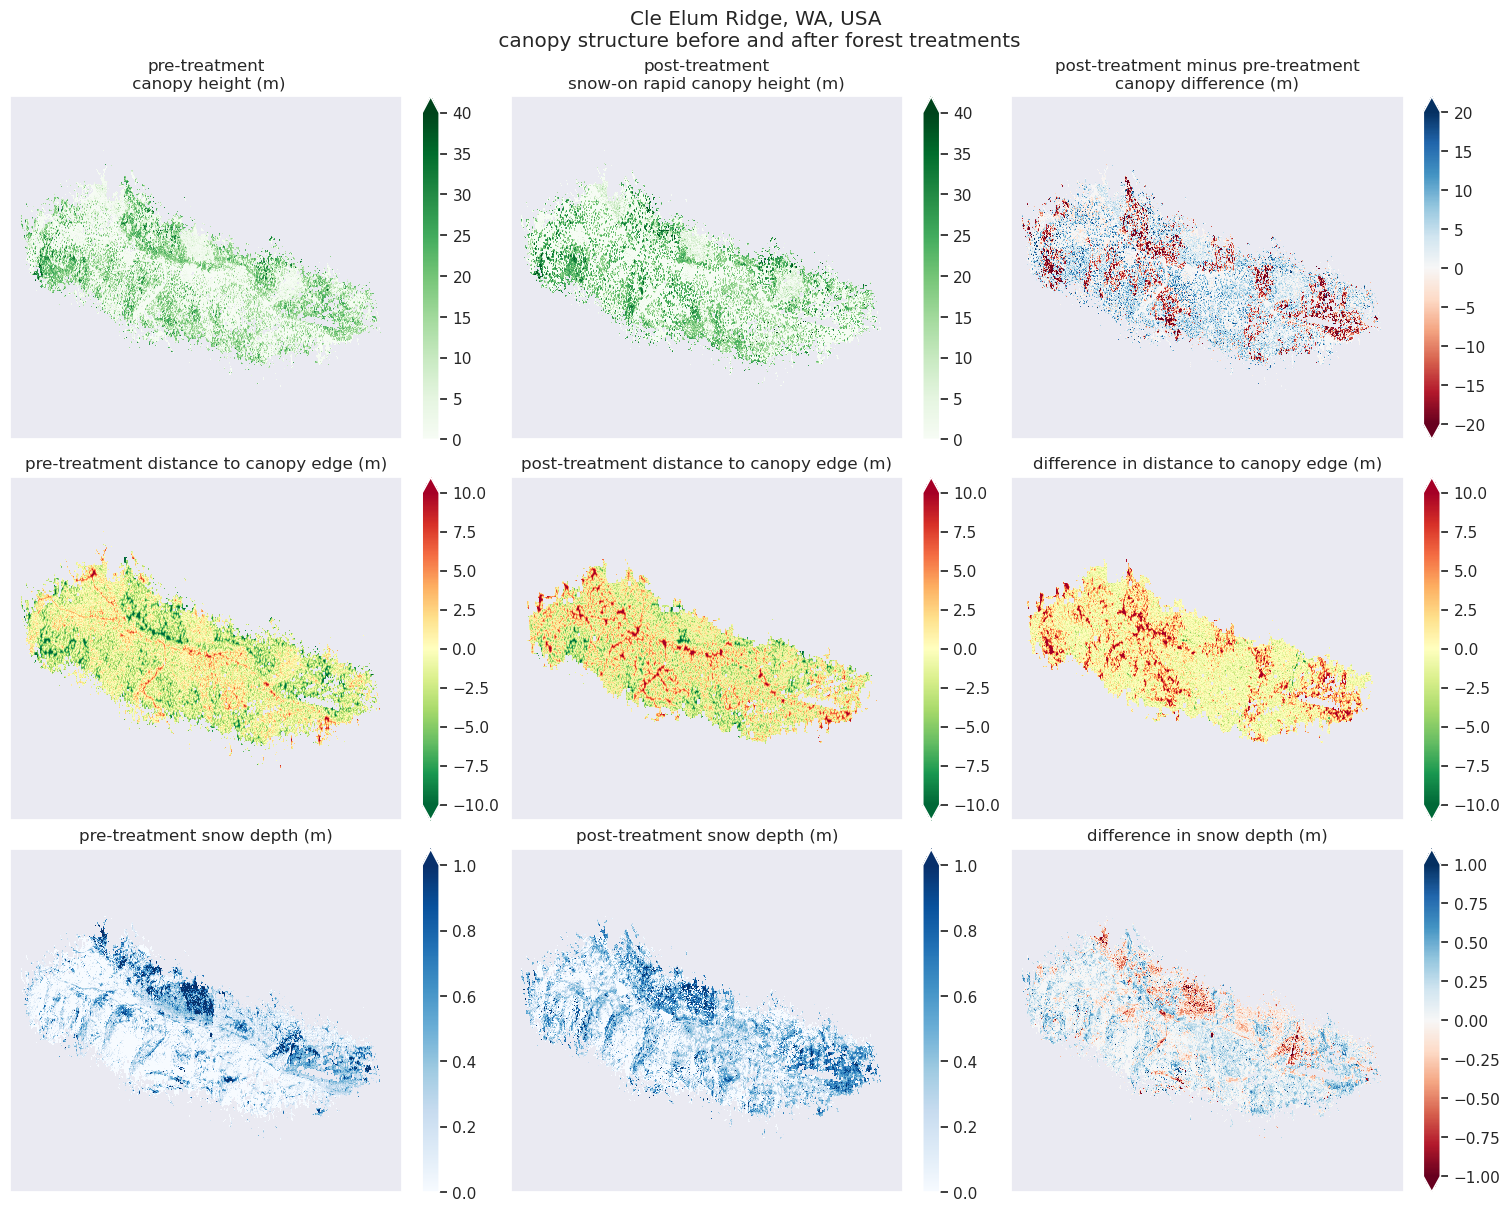

In [ ]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,12), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment snow depth (m)')
axes[2,1].set_title('post-treatment snow depth (m)')
axes[2,2].set_title('difference in snow depth (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

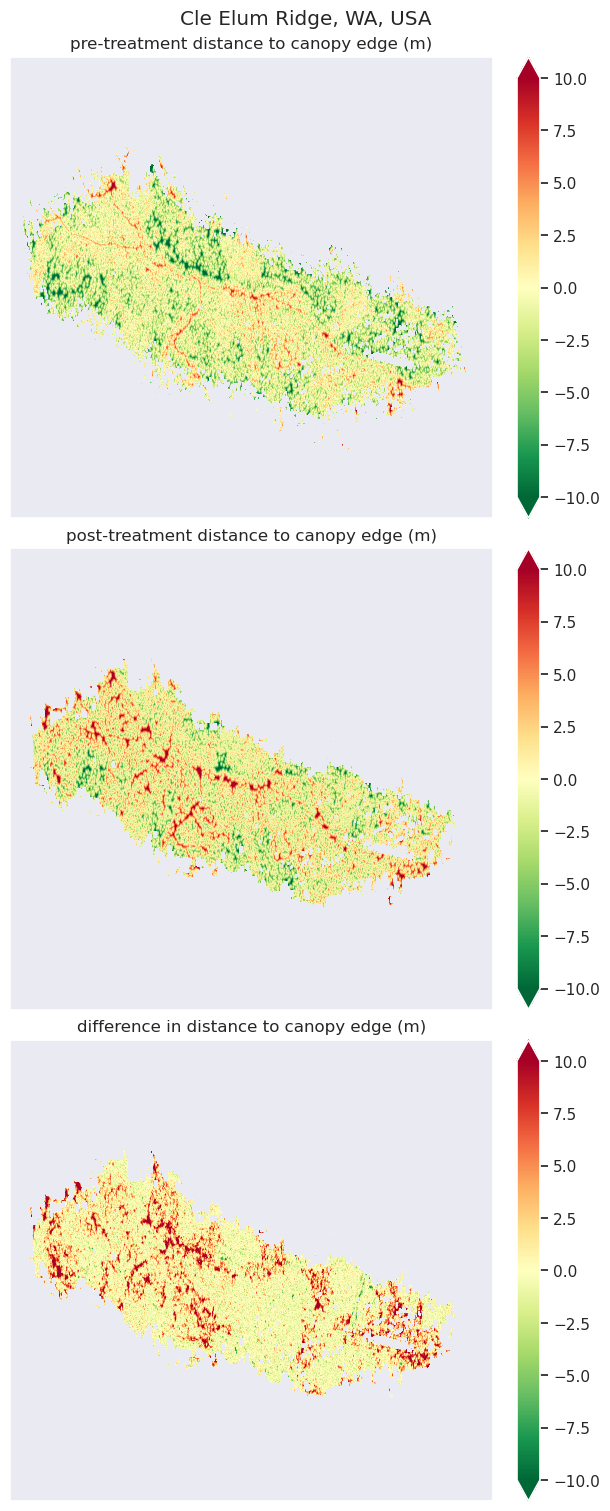

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6,15), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.dce_ncalm.plot(ax=axes[0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0].set_title('pre-treatment distance to canopy edge (m)')
axes[1].set_title('post-treatment distance to canopy edge (m)')
axes[2].set_title('difference in distance to canopy edge (m)')


axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

 Now, let's create a few more plots with DCE and BAF before and after treatments

In [20]:
ds

<xarray.Dataset>
Dimensions:                       (band: 1, y: 1388, x: 2564)
Coordinates:
  * x                             (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                             (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                          (band) int32 1
    spatial_ref                   int32 0
Data variables: (12/79)
    hs_rapid_set1                 (band, y, x) float32 nan nan nan ... nan nan
    hs_rapid_set2                 (band, y, x) float32 nan nan nan ... nan nan
    hs_rapid_set3                 (band, y, x) float32 nan nan nan ... nan nan
    hs_rapid_set2_maskpiles       (band, y, x) float32 nan nan nan ... nan nan
    hs_rapid_set3_maskpiles       (band, y, x) float32 nan nan nan ... nan nan
    chmws_rapid                   (band, y, x) float32 nan nan nan ... nan nan
    ...                            ...
    dce_ncalm_largeclusters       (band, y, x) float32 nan nan nan ... nan nan
    dce_ncalm_smallclusters       (band, y, x) float32 nan nan nan ... nan nan
    dce_ncalm_canopyedges         (band, y, x) float32 nan nan nan ... nan nan
    dce_ncalm_smallgaps           (band, y, x) float32 nan nan nan ... nan nan
    dce_ncalm_largegaps           (band, y, x) float32 nan nan nan ... nan nan
    diff_hs_rapid_ncalm           (band, y, x) float32 nan nan nan ... nan nan

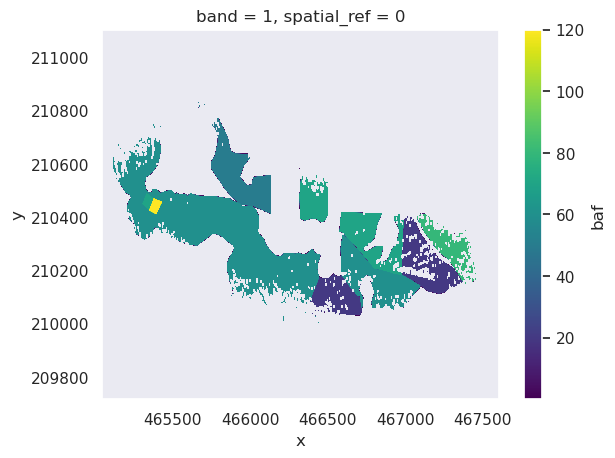

In [22]:
ds['baf'].plot()

In [18]:
ds['dce_rapid_baf_20'] = ds['dce_rapid'].where(ds['baf'] == 20)
ds['dce_rapid_baf_50'] = ds['dce_rapid'].where(ds['baf'] == 50)
ds['dce_rapid_baf_60'] = ds['dce_rapid'].where(ds['baf'] == 60)
ds['dce_rapid_baf_70'] = ds['dce_rapid'].where(ds['baf'] == 70)
ds['dce_rapid_baf_120'] = ds['dce_rapid'].where(ds['baf'] == 120)

In [19]:
ds['dce_ncalm_baf_20'] = ds['dce_rapid'].where(ds['baf'] == 20)
ds['dce_ncalm_baf_50'] = ds['dce_rapid'].where(ds['baf'] == 50)
ds['dce_ncalm_baf_60'] = ds['dce_rapid'].where(ds['baf'] == 60)
ds['dce_ncalm_baf_70'] = ds['dce_rapid'].where(ds['baf'] == 70)
ds['dce_ncalm_baf_120'] = ds['dce_rapid'].where(ds['baf'] == 120)